## Extracting Chess Squares with Perspective Transformation ( image --> fen format)

<br>
<font size="4">
Notebook version of perspective_transformation.py file. You can  understand better all the process by observing cell by cell.<br>  You can use this file for testing 
</font>
<br><br><br><br>

<br>

#### Necessary Libraries

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from ultralytics import YOLO
import  math
import ultralytics
import csv
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from ultralytics import YOLO
from PIL import Image
import os
import chess
import chess.svg


<br>

#### Display Image

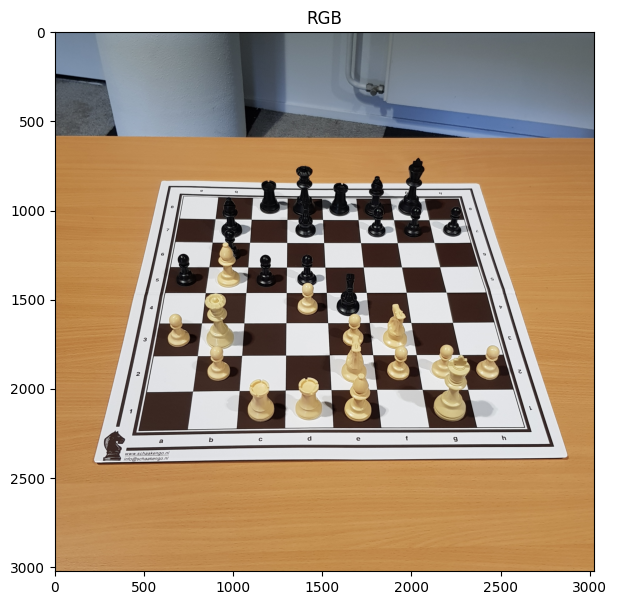

In [64]:
# Path of Image that you want to convert
image_path = r"test-images/test-5.jpeg"
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\87\G087_IMG035.jpg"
# image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\42\G042_IMG000.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\Dynamic-Chess-Board-Piece-Extraction-master\test-images\test-12.jpeg"


# read image and convert it to different color spaces 
image = cv2.imread(image_path)
#image = cv2.resize(image, (1000, 1000))

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

original_size = 1000
scale_factor = image.shape[0] / original_size

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

<br>


## Processing Image 
####  OTSU Threshold , Canny , dilate , HoughLinesP

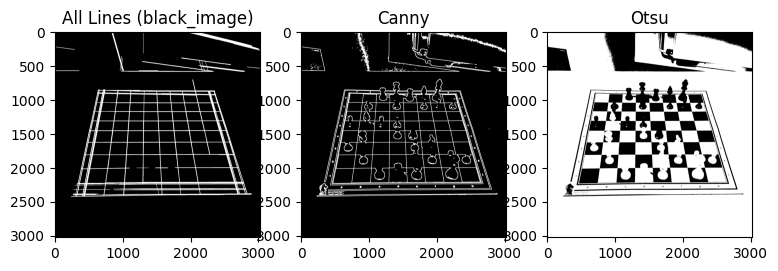

In [65]:

# OTSU threshold
blurred_image = cv2.GaussianBlur(gray_image,(5,5),0)
ret, otsu_binary = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
canny_image = cv2.Canny(otsu_binary, 20, 255)

# Dilation
kernel = np.ones((7, 7), np.uint8)
dilation_image = cv2.dilate(canny_image, kernel, iterations=1)

# Hough Lines
lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)
# lines = link_and_merge_segments_array(lines[:, 0], image.shape[0]*image.shape[1])

# Create an image that contains only black pixels
black_image = np.zeros_like(dilation_image)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))

plt.subplot(1, 3, 1)
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray")


plt.subplot(1, 3, 2)
plt.title("Canny")
plt.imshow(dilation_image,cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Otsu")
plt.imshow(otsu_binary,cmap="gray")

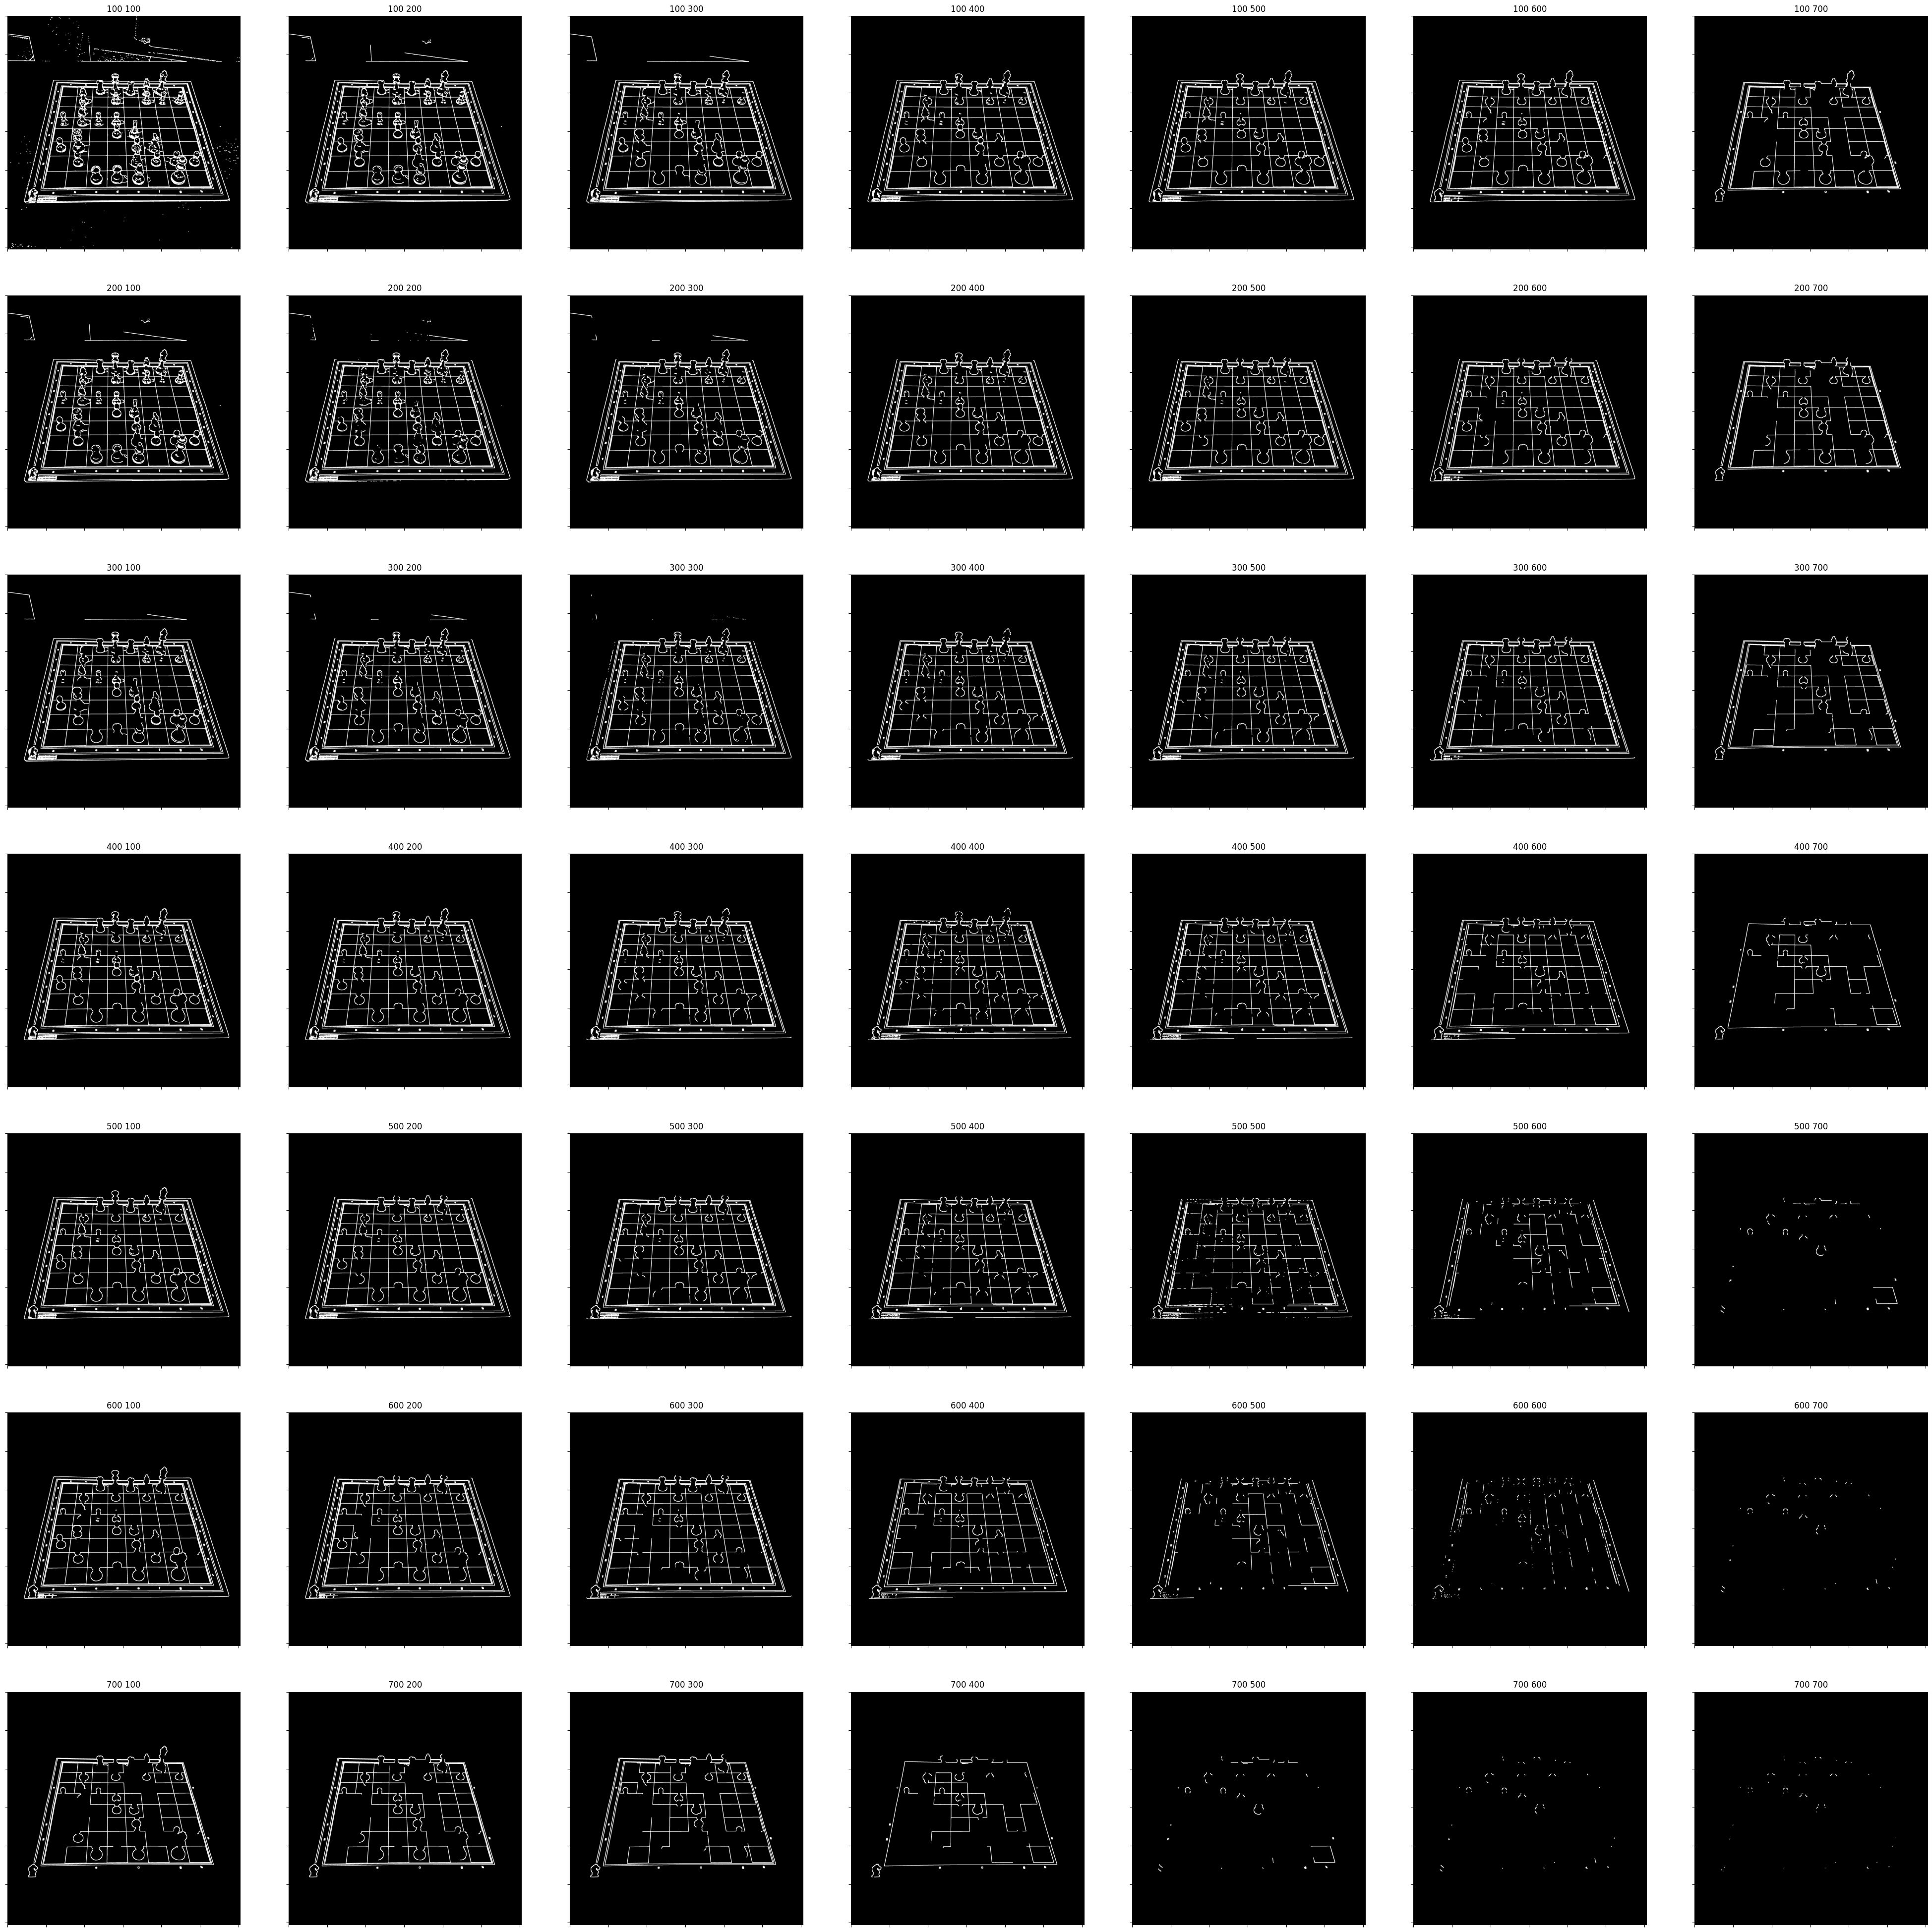

In [66]:
import itertools

t1 = [100, 200, 300, 400, 500, 600, 700]
t2 = [100, 200, 300, 400, 500, 600, 700]

params = [x for x in itertools.product(t1, t2)]

rows = len(t1)
cols = len(t2)

can_kernel = np.ones((7, 7), np.uint8)
plt.figure(figsize=(50,50))
for idx, (t1, t2) in enumerate(params):
    can = cv2.Canny(blurred_image, t1, t2)
    can = cv2.dilate(can, can_kernel, iterations=1)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.title(f'{t1} {t2}')
    plt.imshow(can, cmap='gray')


 <br>


#### Find Contours , sort contours points(4 point), and display valid squares on new fully black image

#### By saying "valid squares" , I mean geometrically. With some threshold value , 4 length of a square must be close to each other 

#### 4 point --> bottomright , topright , topleft , bottomleft

[ 2  3  4  5  6  7  8  9 10 11 12] 12
[ 2  3  4  5  6  7  8 10 11] 11
[ 2  3  4  5  6  7  8  9 11] 11
[ 2  3  4  5  6  7  8  9 10 11] 11
[ 2  3  4  5  6  7  8 11] 11
[ 2  3  4  5  6  7  8 10 11] 11


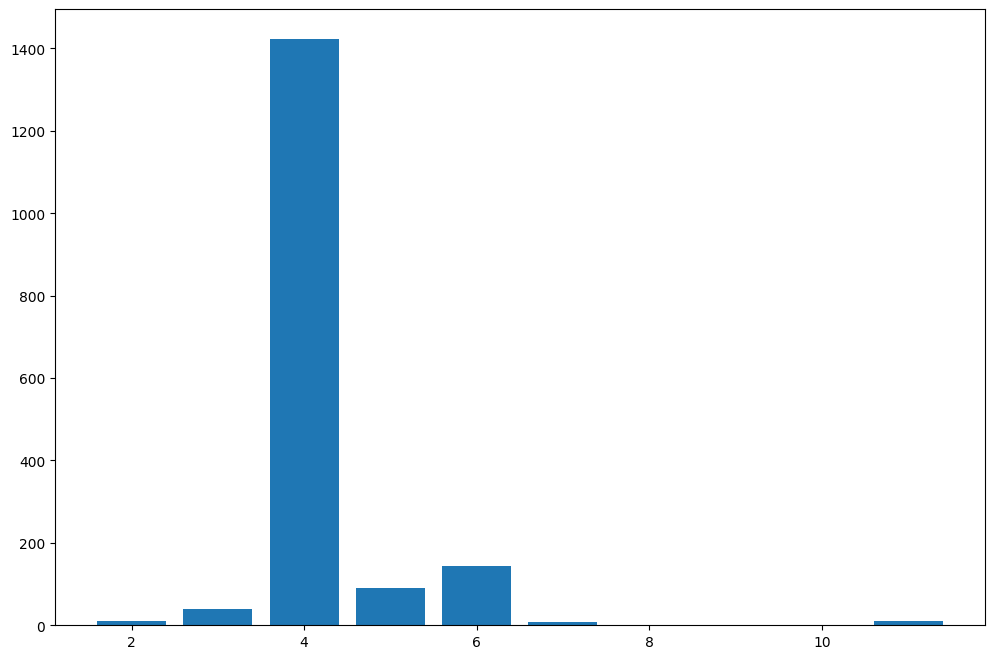

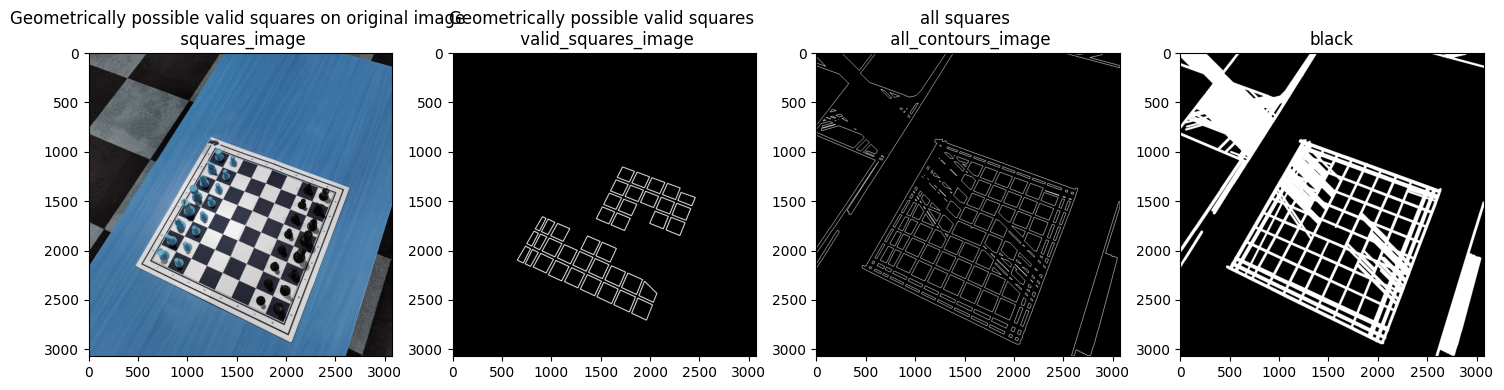

In [43]:
# Look for valid squares and check if squares are inside of board
board_contours = []
all_contours_image= np.zeros_like(black_image)
squares_image = np.copy(image) 
valid_squares_image = np.zeros_like(black_image)
new_black_image = black_image.copy()


# find contours
count = 0 
while True:
    board_contours, hierarchy = cv2.findContours(new_black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = np.array([cv2.contourArea(x) for x in board_contours])
    epsilons = np.array([0.02 * cv2.arcLength(x, True) for x in board_contours])
    polynum = np.array([len(cv2.approxPolyDP(x, 0.02 * cv2.arcLength(x, True), True)) for x in board_contours])

    polynum_cat = np.unique(polynum)
    polynum_nums = []
    for cat in polynum_cat:
        polynum_nums.append(np.sum(polynum[polynum == cat]))

    if count == 6:
        plt.figure(figsize=(12,8))
        plt.bar(polynum_cat, polynum_nums)
        plt.show()
        break

    kernel = np.ones((3, 3), np.uint8)
    new_black_image = cv2.dilate(new_black_image, kernel, iterations=1)
    count += 1

    print(polynum_cat, np.sum(polynum[polynum == cat]))


# loop through contours and filter them by deciding if they are potential squares

for contour in board_contours:
    if 2000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
        # Approximate the contour to a simpler shape
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
            
        if len(approx) == 4:
            # 4 points of polygon
            pts = [pt[0].tolist() for pt in approx]
            # pts = approx[0]

            # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

            #  Y values
            if index_sorted[0][1]< index_sorted[1][1]:
                cur=index_sorted[0]
                index_sorted[0] =  index_sorted[1]
                index_sorted[1] = cur

            if index_sorted[2][1]> index_sorted[3][1]:
                cur=index_sorted[2]
                index_sorted[2] =  index_sorted[3]
                index_sorted[3] = cur

            # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            pt1=index_sorted[0]
            pt2=index_sorted[1]
            pt3=index_sorted[2]
            pt4=index_sorted[3]

            # find rectangle that fits 4 point 
            x, y, w, h = cv2.boundingRect(contour)
            # find center of rectangle 
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            

            # calculate length of 4 side of rectangle
            l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
            l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
            l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)


            # Create a list of lengths
            lengths = [l1, l2, l3, l4]
            
            # Get the maximum and minimum lengths
            max_length = max(lengths)
            min_length = min(lengths)

            # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
            if (max_length - min_length) <= 35 * scale_factor: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                valid_square=True
            else:
                valid_square=False

            if valid_square:
                # Draw only valid squares to "valid_squares_image"
                cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)



plt.figure(figsize=(18,15))

        
plt.subplot(141)
plt.title("Geometrically possible valid squares on original image \n squares_image")
plt.imshow(squares_image,cmap="gray")

plt.subplot(142)
plt.title("Geometrically possible valid squares \n valid_squares_image")

plt.imshow(valid_squares_image, cmap='gray')

plt.subplot(143)
plt.title("all squares \n all_contours_image")

cv2.drawContours(all_contours_image, board_contours, -1, 255, 3)
plt.imshow(all_contours_image,cmap="gray")
plt.subplot(144)
plt.title("black")
plt.imshow(new_black_image, cmap='gray')


<br>


#### Dilation to the image that contains only valid squares (gemoetrically valid)

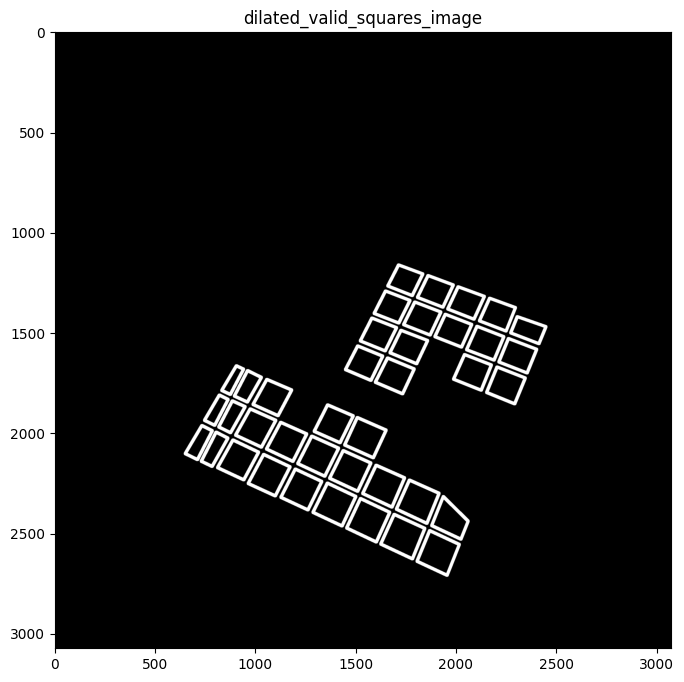

In [44]:
# Apply dilation to the valid_squares_image
kernel = np.ones((7, 7), np.uint8)
dilated_valid_squares_image = cv2.dilate(valid_squares_image, kernel, iterations=1)

plt.figure(figsize=(12,8))
plt.title("dilated_valid_squares_image")
plt.imshow(dilated_valid_squares_image,cmap="gray")

<br>


#### Find biggest contour of image 

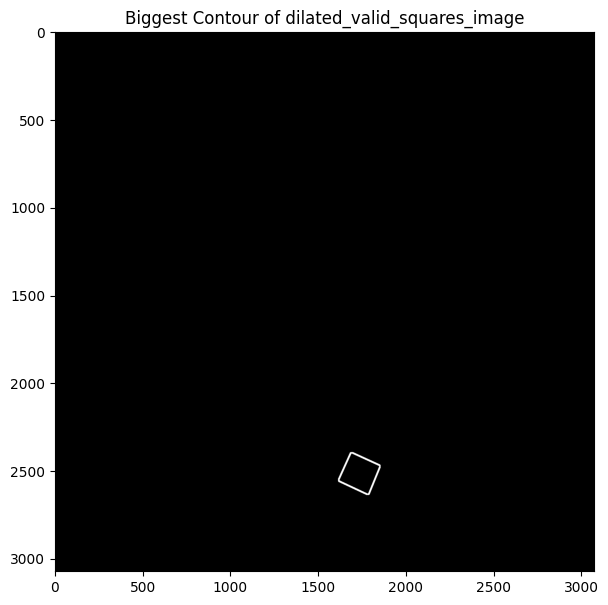

In [45]:
# Find contours of dilated_valid_squares_image
contours, _ = cv2.findContours(dilated_valid_squares_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# take biggest contour 
largest_contour = max(contours, key=cv2.contourArea)

# create black image
biggest_area_image = np.zeros_like(dilated_valid_squares_image)

# draw biggest contour to the image
cv2.drawContours(biggest_area_image,largest_contour,-1,(255,255,255),10)

plt.figure(figsize=(9,7))
plt.title("Biggest Contour of dilated_valid_squares_image")
plt.imshow(biggest_area_image,cmap="gray")

<br><br>
#### Find 4 extreme point of chess board

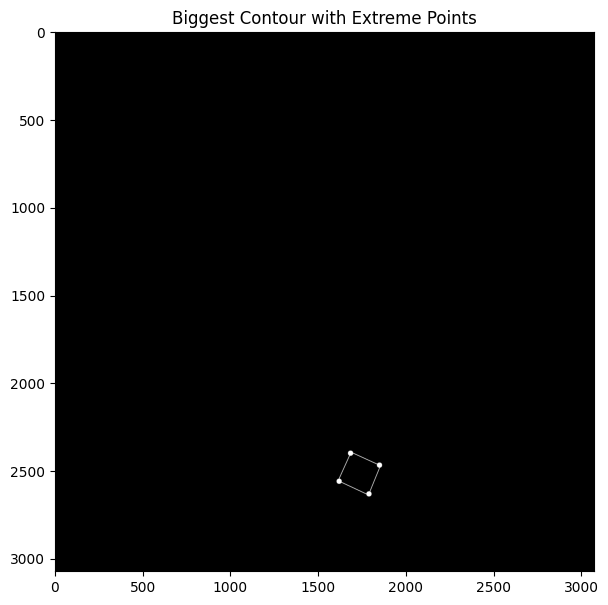

Top-left: (np.int32(1684), np.int32(2400))
Top-right: (np.int32(1849), np.int32(2468))
Bottom-left: (np.int32(1619), np.int32(2560))
Bottom-right: (np.int32(1789), np.int32(2632))


In [46]:
# Initialize variables to store extreme points
top_left = None
top_right = None
bottom_left = None
bottom_right = None

# Loop through the contour to find extreme points
for point in largest_contour[:, 0]:
    x, y = point

    if top_left is None or (x + y < top_left[0] + top_left[1]):
        top_left = (x, y)

    if top_right is None or (x - y > top_right[0] - top_right[1]):
        top_right = (x, y)

    if bottom_left is None or (x - y < bottom_left[0] - bottom_left[1]):
        bottom_left = (x, y)

    if bottom_right is None or (x + y > bottom_right[0] + bottom_right[1]):
        bottom_right = (x, y)

# Draw the contour and the extreme points
extreme_points_image = np.zeros_like(dilated_valid_squares_image, dtype=np.uint8)
cv2.drawContours(extreme_points_image, [largest_contour], -1, (255, 255, 255), thickness=2)

# Mark the extreme points
# Mark the extreme points
cv2.circle(extreme_points_image, top_left, 15, (255, 255, 255), -1)  # red for top-left
cv2.circle(extreme_points_image, top_right, 15, (255, 255, 255), -1)  # green for top-right
cv2.circle(extreme_points_image, bottom_left, 15, (255, 255,255), -1)  # blue for bottom-left
cv2.circle(extreme_points_image, bottom_right, 15, (255, 255, 255), -1)  # yellow for bottom-right


# Display the result
plt.figure(figsize=(9, 7))
plt.title("Biggest Contour with Extreme Points")
plt.imshow(extreme_points_image, cmap="gray")
plt.show()

# Print out the extreme points
print("Top-left:", top_left)
print("Top-right:", top_right)
print("Bottom-left:", bottom_left)
print("Bottom-right:", bottom_right)


<br><br>
#### Apply Perspective Transformation

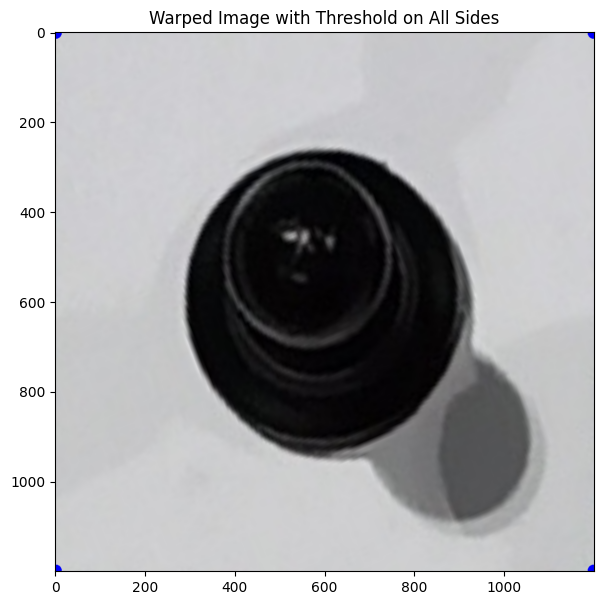

In [47]:
 
# read image and convert it to different color spaces 
# image = cv2.imread(image_path)
# rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Define the four source points (replace with actual coordinates)
extreme_points_list = np.float32([top_left, top_right, bottom_left, bottom_right])

threshold = 0  # Extra space on all sides

width, height = 1200 , 1200 

# Define the destination points (shifted by 'threshold' on all sides)
dst_pts = np.float32([
    [threshold, threshold], 
    [width + threshold, threshold], 
    [threshold, height + threshold], 
    [width + threshold, height + threshold]
])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(extreme_points_list, dst_pts)

# Apply the transformation with extra width and height
warped_image = cv2.warpPerspective(rgb_image, M, (width + 2 * threshold, height + 2 * threshold))

cv2.circle(warped_image, (threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (width + threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (threshold, height + threshold), 15, (0, 0,255), -1)  
cv2.circle(warped_image, (width + threshold, height + threshold), 15, (0, 0, 255), -1)   

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Warped Image with Threshold on All Sides")
plt.show()


<br><br>
#### Divide board to 64 square

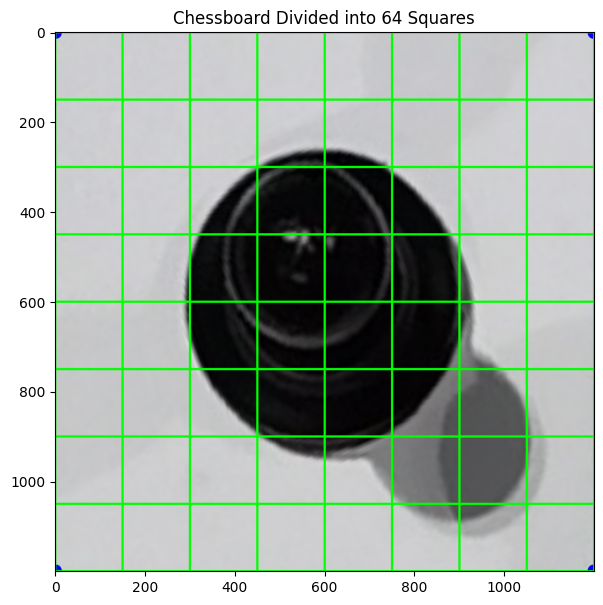

In [48]:
# Assuming area_warped is already defined
# Define number of squares (8x8 for chessboard)
rows, cols = 8, 8

# Calculate the width and height of each square
square_width = width // cols
square_height = height // rows

# Draw the squares on the warped image
for i in range(rows):
    for j in range(cols):
        # Calculate top-left and bottom-right corners of each square
        top_left = (j * square_width, i * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)
        
        # Draw a rectangle for each square
        cv2.rectangle(warped_image, top_left, bottom_right, (0, 255, 0), 4)  # Green color, thickness 2

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Chessboard Divided into 64 Squares")
plt.show()


<br><br>
#### Display extracted squares on original image with inverse transformation

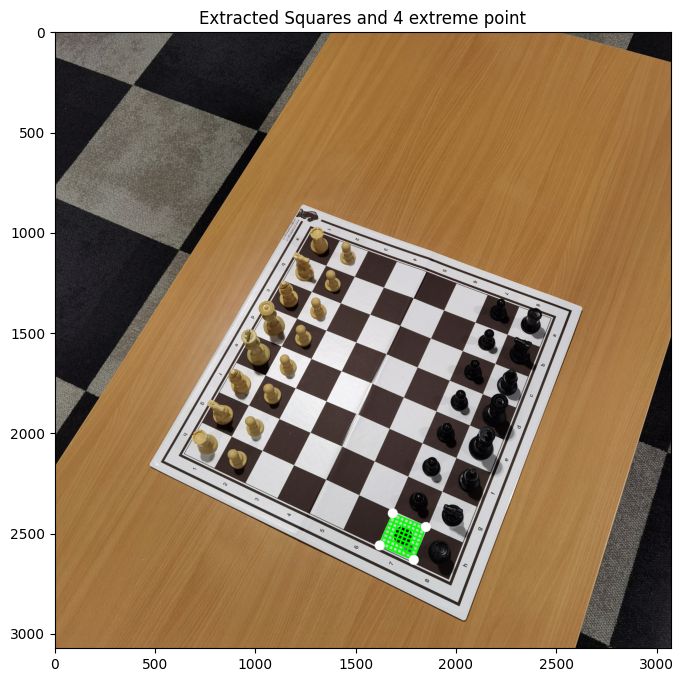

In [49]:
  
# read image and convert it to different color spaces 
#image = cv2.imread(image_path)
#rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


# Compute the inverse perspective transformation matrix
M_inv = cv2.invert(M)[1]  # Get the inverse of the perspective matrix

rows, cols = 8, 8  # 8x8 chessboard

# Calculate the width and height of each square in the warped image
square_width = width // cols
square_height = height // rows

# List to store squares' data in the correct order (bottom-left first)
squares_data_warped = []

for i in range(rows - 1, -1, -1):  # Start from bottom row and move up
    for j in range(cols):  # Left to right order
        # Define the 4 corners of each square
        top_left = (j * square_width, i * square_height)
        top_right = ((j + 1) * square_width, i * square_height)
        bottom_left = (j * square_width, (i + 1) * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)

        # Calculate center of the square
        x_center = (top_left[0] + bottom_right[0]) // 2
        y_center = (top_left[1] + bottom_right[1]) // 2

        # Append to list in the correct order
        squares_data_warped.append([
            (x_center, y_center),
            bottom_right,
            top_right,
            top_left,
            bottom_left
        ])

# Convert to numpy array for transformation
squares_data_warped_np = np.array(squares_data_warped, dtype=np.float32).reshape(-1, 1, 2)

# Transform all points back to the original image
squares_data_original_np = cv2.perspectiveTransform(squares_data_warped_np, M_inv)

# Reshape back to list format
squares_data_original = squares_data_original_np.reshape(-1, 5, 2)  # (num_squares, 5 points, x/y)


for square in squares_data_original:
    x_center, y_center = tuple(map(int, square[0]))  # Convert to int
    bottom_right = tuple(map(int, square[1]))
    top_right = tuple(map(int, square[2]))
    top_left = tuple(map(int, square[3]))
    bottom_left = tuple(map(int, square[4]))

    # Draw necessary lines only (to form grid)
    cv2.line(rgb_image, top_left, top_right, (0, 255, 0), 6)  # Top line
    cv2.line(rgb_image, top_left, bottom_left, (0, 255, 0), 6)  # Left line

    # Draw bottom and right lines only for last row/column
    if j == cols - 1:
        cv2.line(rgb_image, top_right, bottom_right, (0, 255, 0), 8)  # Right line
    if i == 0:
        cv2.line(rgb_image, bottom_left, bottom_right, (0, 255, 0), 8)  # Bottom line

cv2.circle(rgb_image, (int(extreme_points_list[0][0]),int(extreme_points_list[0][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[1][0]),int(extreme_points_list[1][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[2][0]),int(extreme_points_list[2][1])), 25, (255, 255,255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[3][0]),int(extreme_points_list[3][1])), 25, (255, 255, 255), -1)   

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(rgb_image)
plt.title("Extracted Squares and 4 extreme point")
plt.show()

<BR><BR>

    <br>


#### Write coordinate of squares to a csv file

In [50]:
# Write coordinates to CSV file 

with open('extracted-data/board-square-positions-demo.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # columns
    writer.writerow(['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])


    for coordinate in squares_data_original:
        center, bottom_right, top_right, top_left, bottom_left = coordinate
        
        writer.writerow([
                bottom_right[0], bottom_right[1],  # x1, y1
                top_right[0], top_right[1],        # x2, y2
                top_left[0], top_left[1],          # x3, y3
                bottom_left[0], bottom_left[1]     # x4, y4
            ])


<br>


#### Check coordinates of squares that are inside of CSV file

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_13164\1532577031.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pts.append((int(row[j]), int(row[j+1])))


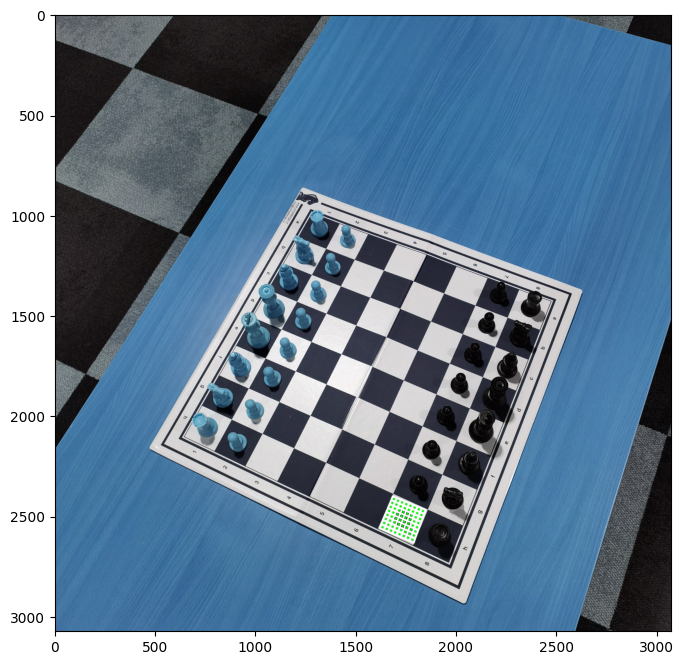

In [51]:
# Check CSV coordinates

data = pd.read_csv("extracted-data/board-square-positions-demo.csv") # true Coordinatesa

# Read the image

# image = cv2.imread(image_path)

# Loop through each row in the DataFrame and draw polygons
for i, row in data.iterrows():
    pts = []
    for j in range(0, 8, 2):
        pts.append((int(row[j]), int(row[j+1])))
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.circle(image, (int(squares_data_original[i][0][0]),int(squares_data_original[i][0][1])), 3, (0,255,0), 3)
    cv2.polylines(image,[pts],True,(255,255,255),thickness=8)  # Change color and thickness as needed

# Display the image
plt.figure(figsize=(10,8))
plt.imshow(image)

<br>

#### CSV

In [52]:
# for creating csv files for coordinates --> Chess-Board/Board_to_csv.ipynb
coordinates=pd.read_csv("extracted-data/board-square-positions-demo.csv")
coordinates.tail()


x1         y1         x2         y2         x3         y3  \
59  1758.4994  2453.4895  1766.0880  2433.8303  1745.4893  2425.3410   
60  1779.2260  2462.0600  1786.7383  2442.3406  1766.0880  2433.8303   
61  1800.0046  2470.6520  1807.4402  2450.8723  1786.7383  2442.3406   
62  1820.8356  2479.2659  1828.1941  2459.4255  1807.4402  2450.8723   
63  1841.7191  2487.9011  1849.0000  2468.0000  1828.1941  2459.4255   

           x4         y4  
59  1737.8246  2444.9407  
60  1758.4994  2453.4895  
61  1779.2260  2462.0600  
62  1800.0046  2470.6520  
63  1820.8356  2479.2659

<br>

#### Create dictionary for squares coordinates

In [53]:
# dictionary for every cell's boundary coordinates 
# [[334, 1231], [344, 1139], [262, 1137], [247, 1228]] -->x1,y1,x2,y2,x3,y3,x4,y4
# 64 cell_value in total --> 8x8 board

coord_dict={}

cell=1
for row in coordinates.values:
    coord_dict[cell]=[[row[0],row[1]],[row[2],row[3]],[row[4],row[5]],[row[6],row[7]]]
    cell+=1
    
print(coord_dict[1])
print(coord_dict[2])
print(len(coord_dict))

[[np.float64(1640.0587), np.float64(2568.919)], [np.float64(1648.3461), np.float64(2548.2615)], [np.float64(1627.366), np.float64(2539.4067)], [np.float64(1619.0), np.float64(2560.0)]]
[[np.float64(1661.1716), np.float64(2577.8608)], [np.float64(1669.3799), np.float64(2557.1392)], [np.float64(1648.3461), np.float64(2548.2615)], [np.float64(1640.0587), np.float64(2568.919)]]
64


<br>

#### Label Dictionary

In [54]:
# class values , these values are decided before training
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook'] # type: ignore
class_dict={0:'black-bishop',1:'black-king',2:'black-knight',3:'black-pawn',4: 'black-queen',5: 'black-rook',
            6:'white-bishop',7:'white-king',8: 'white-knight',9: 'white-pawn',10: 'white-queen',11:'white-rook'}

<br>

#### Make prediction


image 1/1 D:\Projects\Uni\Chessy3D\data\ra2k\images\42\G042_IMG000.jpg: 640x640 1 black-bishop, 2 black-kings, 3 black-knights, 8 black-pawns, 1 black-queen, 1 black-rook, 2 white-bishops, 1 white-king, 2 white-knights, 8 white-pawns, 1 white-queen, 3 white-rooks, 205.5ms
Speed: 4.3ms preprocess, 205.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


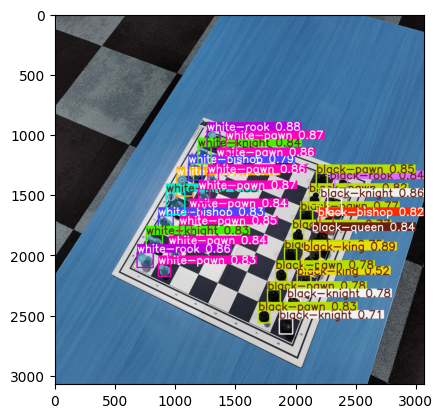

In [55]:
# YOLOv8  model
#image_path = r'D:\Projects\Uni\Chessy3D\data\ra2k\images\87\G087_IMG019.jpg'
model = YOLO("chess-model-yolov8m.pt") 

# make prediction
results = model(image_path) # path to test image
im_array = results[0].plot() # plot a BGR numpy array of predictions

plt.imshow(im_array)

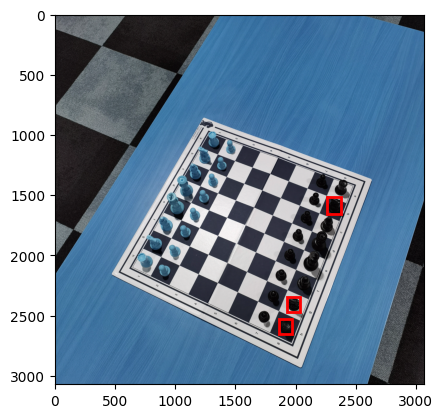

In [56]:
from torchvision.ops import box_iou
import torch
import matplotlib.patches as patches


result = results[0]
boxes = results[0].boxes.xyxy  # Extract boxes from the first result
boxes = boxes.cpu()

ious = box_iou(boxes, boxes)

# Threshold for overlap
eta = 2000

# Find overlapping boxes
overlapping_indices = (ious > eta) & (ious < 1.0)

image = cv2.imread(image_path)

# Plot only the filtered boxes
fix, ax = plt.subplots()
ax.imshow(image)

filtered_boxes = result.boxes.xyxy[result.boxes.cls == 2]
for box in filtered_boxes:
    x1, y1, x2, y2 = map(int, box.tolist())
    color = (0, 255, 0)  # Green for the target class
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, color='red', fill=False))

# Show the image with filtered boxes
plt.show()



In [57]:
results[0].names[results[0].boxes[0].cls.item()]

'black-king'

<br>

#### "game_list" is a list that contains information about game 

In [58]:
# list for cell number and piece id (class value)
game_list=[]

for result in results:  # results is model's prediction     
    for id,box in enumerate(result.boxes.xyxy) : # box with xyxy format, (N, 4)
            
            x1,y1,x2,y2=int(box[0]),int(box[1]),int(box[2]),int(box[3]) # take coordinates 

            # find middle of bounding boxes for x and y 
            x_mid=int((x1+x2)/2) 
            # add padding to y values
            y_mid=int((y1+y2)/2)+25

            for cell_value, coordinates in coord_dict.items():
                x_values = [point[0] for point in coordinates]
                y_values = [point[1] for point in coordinates]
                 
                if (min(x_values) <= x_mid <= max(x_values)) and (min(y_values) <= y_mid <= max(y_values)):
                    a=int(result.boxes.cls[id])

                    print(f" cell :  {cell_value} --> {a} ")
                    # add cell values and piece cell_value(class value
                    game_list.append([cell_value,a]) 
                    break
        
            
            
 

 cell :  21 --> 3 


<br>

#### Create String that contains game info

In [59]:
# show game , if cell value exist in game_list , then print piece in that cell , otherwise print space 
chess_str=""
for i in range(1, 65):
    
    for slist in game_list:
        if slist[0] == i:
            print(class_dict[slist[1]], end=" ")
            chess_str+=f" {class_dict[slist[1]]} "
            break
    else:
        print("space", end=" ")
        chess_str+=" space "

    if i % 8 == 0:
        print("\n")
        chess_str+="\n"

space space space space space space space space 

space space space space space space space space 

space space space space black-pawn space space space 

space space space space space space space space 

space space space space space space space space 

space space space space space space space space 

space space space space space space space space 

space space space space space space space space 



<br>

#### Create Classical Chess Image(fen format) in .SVG format 

In [60]:
import chess
import chess.svg

def parse_coordinates(input_str):
    """
    Parse the input string to extract the positions of the chess pieces.
    """
    rows = input_str.strip().split('\n')
    chess_pieces = []
    for row in rows:  # Reversing rows to invert ranks
        pieces = row.strip().split()
        chess_pieces.extend(pieces)
    return chess_pieces

 
input_str=chess_str

chess_pieces = parse_coordinates(input_str)

board = chess.Board(None)

piece_mapping = {
    'white-pawn': chess.PAWN,
    'black-pawn': chess.PAWN,
    'white-knight': chess.KNIGHT,
    'black-knight': chess.KNIGHT,
    'white-bishop': chess.BISHOP,
    'black-bishop': chess.BISHOP,
    'white-rook': chess.ROOK,
    'black-rook': chess.ROOK,
    'white-queen': chess.QUEEN,
    'black-queen': chess.QUEEN,
    'white-king': chess.KING,
    'black-king': chess.KING,
    'space': None
}

for rank in range(8):
    for file in range(8):
        piece = chess_pieces[rank * 8 + file]
        if piece != 'space':
            print(rank)
            print(file)
            color = chess.WHITE if piece.startswith('white') else chess.BLACK
            piece_type = piece_mapping[piece]
            board.set_piece_at(chess.square(file, rank), chess.Piece(piece_type, color))  # Not inverting rank

svgboard = chess.svg.board(board)
with open("extracted-data/2Dboard.svg", "w") as f:
    f.write(svgboard)




2
4


<br><br>

#### Convert .SVG to .jpeg and display Result

Converted extracted-data/2Dboard.svg to extracted-data/Extracted-Board.jpeg


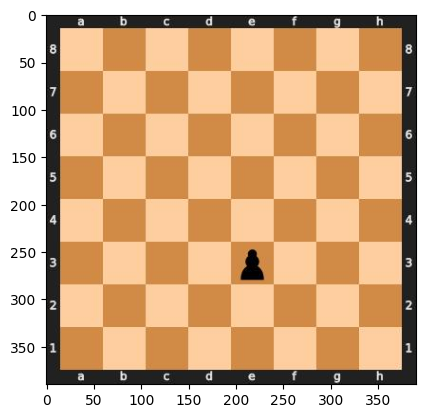

In [61]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Function to convert SVG to PNG
def convert_svg_to_png(svg_file_path, png_file_path):
    # Read the SVG file and convert it to a ReportLab Drawing
    drawing = svg2rlg(svg_file_path)
    # Render the drawing to a PNG file
    renderPM.drawToFile(drawing, png_file_path, fmt='jpeg')
    print(f"Converted {svg_file_path} to {png_file_path}")

# Example usage
svg_file = 'extracted-data/2Dboard.svg'
png_file = 'extracted-data/Extracted-Board.jpeg'
convert_svg_to_png(svg_file, png_file)

original_image = cv2.imread(image_path)
original_image=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
 
plt.imshow(cv2.cvtColor(cv2.imread(png_file),cv2.COLOR_BGR2RGB))

<br><br>

#### Display Original Image and Converted Image

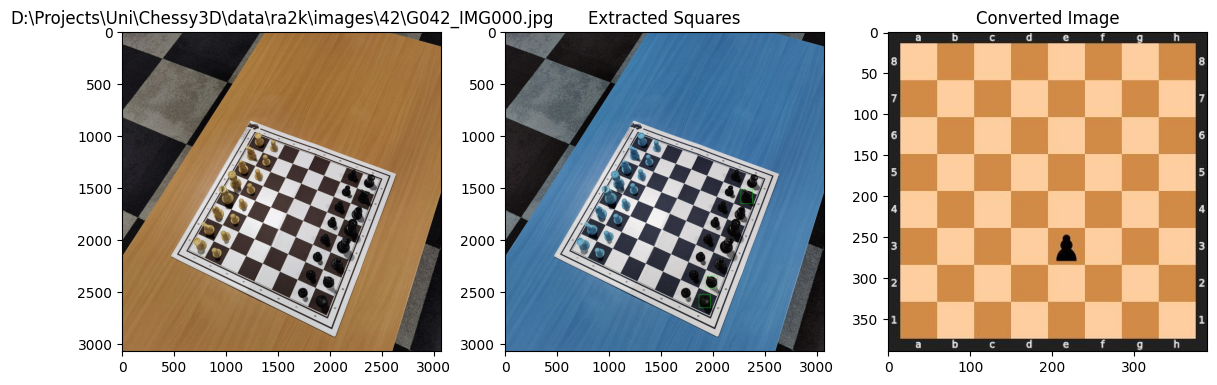

In [62]:
plt.figure(figsize=(14, 10))  # Increase the figure size to 18x6 inches


plt.subplot(131)
plt.title(f"{image_path}")
plt.imshow(original_image)

plt.subplot(132)
plt.title("Extracted Squares")
plt.imshow(image)

plt.subplot(133)
plt.title("Converted Image")
plt.imshow(cv2.cvtColor(cv2.imread(png_file),cv2.COLOR_BGR2RGB))

# Save the figure as a PNG file
output_path = 'output_figure.png'
plt.savefig(output_path)

plt.show()  

<br><br><br>